In [3]:
pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=b7f1c3ae499786c7d7f97471ced2099ad77394e5cfafc35258b3fdca8858823b
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


# **IMPORT CÁC THƯ VIỆN CẦN THIẾT**

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from imutils import paths
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from keras.utils import to_categorical
from sklearn.svm import SVC
from joblib import dump, load, Parallel, delayed

2024-07-10 08:10:08.001727: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 08:10:08.001907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 08:10:08.174484: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **LOAD VÀ XỬ LÍ DỮ LIỆU**

In [5]:
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

In [6]:
# Danh sách cảm xúc
emotions = ['disgust', 'fear', 'happy', 'surprise']

In [7]:
# Hàm để phát hiện khuôn mặt
def detect_faces(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces

In [8]:
# Hàm để trích xuất đặc trưng HOG từ khuôn mặt
def extract_hog_features(image):
    fd = hog(image, orientations=7, pixels_per_cell=(8, 8), cells_per_block=(4, 4), block_norm='L2-Hys', transform_sqrt=False)
    return fd

In [9]:
# Hàm để đọc dữ liệu từ thư mục
def load_data(directory):
    data = []
    labels = []
    for emotion in emotions:
        emotion_dir = os.path.join(directory, emotion)
        imagePaths = list(paths.list_images(emotion_dir))
        for imagePath in imagePaths:
            image = cv2.imread(imagePath)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            faces = detect_faces(gray)
            for (x, y, w, h) in faces:
                face = gray[y:y+h, x:x+w]
                face_resized = cv2.resize(face, (48, 48))
                hog_features = extract_hog_features(face_resized)
                data.append(hog_features)
                labels.append(emotion)
    return np.array(data), np.array(labels)

In [10]:
# Tải dữ liệu
X_train, y_train = load_data(train_dir)
X_test, y_test = load_data(test_dir)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [12]:
# Xuất ra số lượng đặc trưng và số lượng mẫu
print(f"Number of features: {X_train.shape[1]}")
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of validation samples: {X_val.shape[0]}")
print(f"Number of test samples: {X_test.shape[0]}")

Number of features: 1008
Number of training samples: 2924
Number of validation samples: 731
Number of test samples: 902


# **SVM**

Best parameters found:  {'C': 1, 'kernel': 'rbf'}
Train Accuracy: 0.9131326949384405
Train Classification Report:
              precision    recall  f1-score   support

     disgust       1.00      0.52      0.68        99
        fear       0.88      0.80      0.84       551
       happy       0.92      0.99      0.95      1720
    surprise       0.90      0.87      0.88       554

    accuracy                           0.91      2924
   macro avg       0.93      0.79      0.84      2924
weighted avg       0.91      0.91      0.91      2924



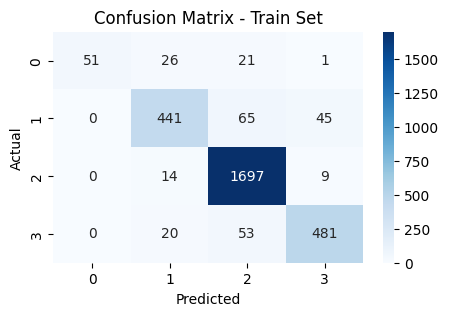

Validation Accuracy: 0.801641586867305
Validation Classification Report:
              precision    recall  f1-score   support

     disgust       1.00      0.30      0.46        30
        fear       0.73      0.58      0.65       161
       happy       0.85      0.95      0.90       400
    surprise       0.72      0.72      0.72       140

    accuracy                           0.80       731
   macro avg       0.82      0.64      0.68       731
weighted avg       0.80      0.80      0.79       731



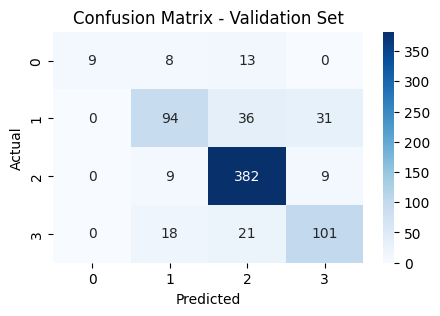

Test Accuracy: 0.8093126385809313
Test Classification Report:
              precision    recall  f1-score   support

     disgust       1.00      0.24      0.39        33
        fear       0.70      0.61      0.65       189
       happy       0.85      0.96      0.90       510
    surprise       0.76      0.70      0.73       170

    accuracy                           0.81       902
   macro avg       0.83      0.63      0.67       902
weighted avg       0.81      0.81      0.80       902



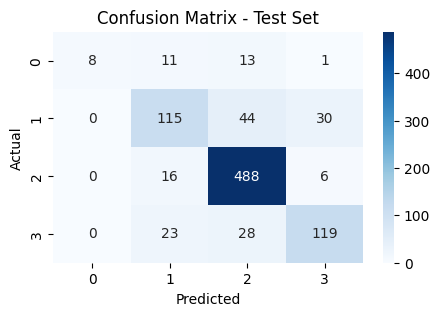

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Sử dụng Grid Search để tìm tham số tốt nhất
param_grid = {'C': [0.1, 1], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(SVC(), param_grid, cv=3)
grid_search.fit(X_train, y_train)

# In ra tham số tốt nhất
print("Best parameters found: ", grid_search.best_params_)

# Sử dụng mô hình với tham số tốt nhất
best_svm_clf = grid_search.best_estimator_

# Đánh giá mô hình trên tập huấn luyện
y_train_pred = best_svm_clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)
print("Train Classification Report:")
print(classification_report(y_train, y_train_pred))

# Xuất ra confusion matrix cho tập huấn luyện
train_cm = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(5,3))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Đánh giá mô hình trên tập xác thực
y_val_pred = best_svm_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Xuất ra confusion matrix cho tập xác thực
val_cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(5,3))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Đánh giá mô hình trên tập kiểm tra
y_test_pred = best_svm_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Xuất ra confusion matrix cho tập kiểm tra
test_cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,3))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **DEMO**

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from imutils import paths
from joblib import load

# Hàm phát hiện khuôn mặt
def detect_faces(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces

# Hàm trích xuất đặc trưng HOG từ khuôn mặt
def extract_hog_features(image):
    fd = hog(image, orientations=7, pixels_per_cell=(8, 8), cells_per_block=(4, 4), block_norm='L2-Hys')
    return fd

# Hàm để dự đoán và lưu kết quả
def load_and_predict(imagePath, model, output_dir):
    image = cv2.imread(imagePath)
    if image is None:
        print(f"Không thể đọc ảnh từ đường dẫn: {imagePath}")
        return None, None
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detect_faces(gray)
    if len(faces) == 0:
        print(f"No faces detected in image: {imagePath}")
        return None, None
    
    prediction = None
    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        face_resized = cv2.resize(face, (48, 48))
        hog_features = extract_hog_features(face_resized)
        hog_features = hog_features.reshape(1, -1)
        prediction = model.predict(hog_features)[0]
        
        # Thêm nhãn dự đoán vào ảnh
        cv2.putText(image, f"Predicted: {prediction}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)
        cv2.rectangle(image, (x, y), (x+w, y+h), (36, 255, 12), 2)
        
    # Xác định đường dẫn lưu ảnh đầu ra
    output_path = os.path.join(output_dir, f"{os.path.basename(imagePath).split('.')[0]}_pred_{prediction}.jpg")
    
    # Lưu ảnh với nhãn dự đoán
    cv2.imwrite(output_path, image)
    
    return prediction, output_path

**SVM**

In [ ]:
# Tải mô hình đã huấn luyện
best_svm_clf = load('svm_emotion_recognition.joblib')

# Đường dẫn tới thư mục ảnh ngoài để dự đoán
external_image_dir = '/kaggle/input/.......'
output_dir = '/kaggle/working/predictions'

# Tạo thư mục lưu kết quả nếu chưa tồn tại
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Duyệt qua từng ảnh, dự đoán và lưu kết quả
predictions = []
no_face_detected = []
for filename in os.listdir(external_image_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        imagePath = os.path.join(external_image_dir, filename)
        prediction, output_path = load_and_predict(imagePath, best_svm_clf, output_dir)
        if prediction is not None:
            predictions.append((imagePath, prediction, output_path))
            print(f'Image: {filename}, Predicted Label: {prediction}, Saved As: {output_path}')
        else:
            no_face_detected.append(imagePath)

# Lưu danh sách các dự đoán và đường dẫn ảnh
predictions, no_face_detected

In [ ]:
index = 0
if index < len(predictions):
    imagePath, prediction, output_path = predictions[index]
    image = cv2.imread(output_path)
    if image is None:
        print(f"Failed to read image: {output_path}")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(5, 5))
        plt.imshow(image_rgb)
        plt.title(f"Predicted: {prediction}")
        plt.axis('off')
        plt.show()
else:
    print("No face detected in this image.")

In [ ]:
index = 1
if index < len(predictions):
    imagePath, prediction, output_path = predictions[index]
    image = cv2.imread(output_path)
    if image is None:
        print(f"Failed to read image: {output_path}")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(5, 5))
        plt.imshow(image_rgb)
        plt.title(f"Predicted: {prediction}")
        plt.axis('off')
        plt.show()
else:
    print("No face detected in this image.")

In [ ]:
index = 2
if index < len(predictions):
    imagePath, prediction, output_path = predictions[index]
    image = cv2.imread(output_path)
    if image is None:
        print(f"Failed to read image: {output_path}")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(5, 5))
        plt.imshow(image_rgb)
        plt.title(f"Predicted: {prediction}")
        plt.axis('off')
        plt.show()
else:
    print("No face detected in this image.")

In [ ]:
index = 3
if index < len(predictions):
    imagePath, prediction, output_path = predictions[index]
    image = cv2.imread(output_path)
    if image is None:
        print(f"Failed to read image: {output_path}")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(5, 5))
        plt.imshow(image_rgb)
        plt.title(f"Predicted: {prediction}")
        plt.axis('off')
        plt.show()
else:
    print("No face detected in this image.")

In [ ]:
index = 4
if index < len(predictions):
    imagePath, prediction, output_path = predictions[index]
    image = cv2.imread(output_path)
    if image is None:
        print(f"Failed to read image: {output_path}")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(5, 5))
        plt.imshow(image_rgb)
        plt.title(f"Predicted: {prediction}")
        plt.axis('off')
        plt.show()
else:
    print("No face detected in this image.")

# **DEMO ẢNH TỰ CHỤP**

In [ ]:
# Đường dẫn tới thư mục ảnh ngoài để dự đoán
external_image_dir = '/kaggle/input/data2testmodelcs231/test_cs231'
output_dir = '/kaggle/working/predictions'

# Tạo thư mục lưu kết quả nếu chưa tồn tại
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Duyệt qua từng ảnh, dự đoán và lưu kết quả
predictions = []
no_face_detected = []
for filename in os.listdir(external_image_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        imagePath = os.path.join(external_image_dir, filename)
        prediction, output_path = load_and_predict(imagePath, best_svm_clf, output_dir)
        if prediction is not None:
            predictions.append((imagePath, prediction, output_path))
            print(f'Image: {filename}, Predicted Label: {prediction}, Saved As: {output_path}')
        else:
            no_face_detected.append(imagePath)

# Lưu danh sách các dự đoán và đường dẫn ảnh
predictions, no_face_detected

In [ ]:
index = 0
if index < len(predictions):
    imagePath, prediction, output_path = predictions[index]
    image = cv2.imread(output_path)
    if image is None:
        print(f"Failed to read image: {output_path}")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(5, 5))
        plt.imshow(image_rgb)
        plt.title(f"Predicted: {prediction}")
        plt.axis('off')
        plt.show()
else:
    print("No face detected in this image.")

In [ ]:
index = 1
if index < len(predictions):
    imagePath, prediction, output_path = predictions[index]
    image = cv2.imread(output_path)
    if image is None:
        print(f"Failed to read image: {output_path}")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(5, 5))
        plt.imshow(image_rgb)
        plt.title(f"Predicted: {prediction}")
        plt.axis('off')
        plt.show()
else:
    print("No face detected in this image.")

In [ ]:
index = 2
if index < len(predictions):
    imagePath, prediction, output_path = predictions[index]
    image = cv2.imread(output_path)
    if image is None:
        print(f"Failed to read image: {output_path}")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(5, 5))
        plt.imshow(image_rgb)
        plt.title(f"Predicted: {prediction}")
        plt.axis('off')
        plt.show()
else:
    print("No face detected in this image.")